In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append("src")
import VirtualInstrument
import ParamGenerator as SG
import json
import TreeHierarchy as TH
from scipy.stats.qmc import LatinHypercube
import ArrayTuner
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import os

# Random sampling function
For every morphology in the dataset we need a function that can generate a set of random examples, random draws of the structural parameters.  This portion of the code certainly contains a level of techinical debt and is ripe for improvement when genrealizing the model to new tasks. Each morphology is assigned one function that merely takes the number of desired samples as an argument. All the mins and maxes as well as the sampling type (uniform vs logarithmic are the most common choices) are baked into these functions. 

In [2]:
numeric_params = ['radius', 'length', 'thick_sell', 'thick_solvent', 'background', 'scale', 'n_shells', 'sld' ,'sld_core', 'sld_solvent', 'sld_shell', 'radius_pd_n', 'length_pd_n', 'radius_pd_nsigma', 'length_pd_nsigma', 'kuhn_length', 'radius_pd', 'length_pd']

In [3]:
reference_files = ["data/bg_sub/S_r30405_0p1_Bicelles_100mM_NaCl.csv"]
vi = VirtualInstrument.VirtualInstrument()
vi.add_references(reference_files)
refdf = pd.DataFrame(pd.read_csv(reference_files[0], sep='\s+'))
erf = np.array(refdf.loc[:,'dI'])
q = np.array(refdf.loc[:,'q'])

Index(['q', 'I', 'dI', 'dq'], dtype='object')


/home/grahamroberts/qyangwork/exsas/SASML2.0/src/VirtualInstrument.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fn, delim_whitespace=True)


In [4]:
def random_MLS(count):
    n_shells = np.random.randint(5, 30, count)
    radii = np.random.uniform(90, 200, count)
    shell_thick = np.random.uniform(35,50,count)
    water_thick = np.random.uniform(100,25,count)
    scales = np.random.uniform(0.001, 0.15, count)
    sld= np.random.uniform(1., 1., count)
    radius_pds = np.random.uniform(0.1, 0.3, count)
    #background = np.random.uniform(-3.5,-1,count)
    #sld_solvent = np.random.uniform(4.4,8.4,count)
    #scale = np.random.uniform(0.1, 1.0, count)
    return_list = [{"n_shells": n_shells[i],
                    "radius": radii[i],
                    "thick_shell": shell_thick[i],
                    "scale": scales[i],
                    "sld": sld[i],
                    "radius_pd": radius_pds[i],
                    "radius_pd_type":"schulz",
                    "radius_pd_n": 8,
                    "radius_pd_nsigma": 30,
                    "thick_solvent": water_thick[i]} for i in range(count)]
        #            "background": 10**background[i],
        #            "sld_solvent": sld_solvent[i],
        #            "sld": sld[i]} for i in range(count)]
    return(return_list)

In [5]:
def random_cylinder(count):
    radii = np.random.uniform(10, 2500, count)
    length = np.random.uniform(25, 500, count)
    sld = np.random.uniform(.5, 3.0, count)
    radius_pds = np.random.uniform(0.1, 0.3, count)
    #background = np.random.uniform(-3.5,-1,count)
    scales = np.random.uniform(0.0005, 0.05, count)

    #sld_solvent = np.random.uniform(4.4,8.4,count)
    #scale = np.random.uniform(0.1, 1.0, count)
    return_list = [{"radius":radii[i],
                    "scale": scales[i],
                    "sld": sld[i],
                    "radius_pd": radius_pds[i],
                    "radius_pd_type":"schulz",
                    "radius_pd_n": 8,
                    "radius_pd_nsigma": 30,
                    "length":2*radii[i]+length[i]} for i in range(count)]
           #         "background": 10**background[i],
           #         "sld_solvent": sld_solvent[i],
           #         "scale": scale[i],
           #         "sld":sld[i]} for i in range(count)]
    return(return_list)

In [6]:

def random_disk(count):
    radii = np.random.uniform(30.0, 100.0, count)
    length = np.random.uniform(40.0, 60.0, count)
    scales = np.random.uniform(0.001, 0.15, count)
    length_pds = np.random.uniform(0.1, 0.3, count)
    #background = np.random.uniform(-3.5,-1,count)
    #sld_solvent = np.random.uniform(4.4,8.4,count)
    #scale = np.random.uniform(0.1, 1.0, count)
    sld = np.random.uniform(1., .0, count)
    return_list = [{"radius":length[i]+radii[i],
                    "scale": scales[i],
                    "sld": sld[i],
                    "radius_pd": length_pds[i],
                    "radius_pd_type":"schulz",
                    "radius_pd_n": 8,
                    "radius_pd_nsigma": 30,
                    "length":length[i]} for i in range(count)]
     #               "background": 10**background[i],
     #               "sld_solvent": sld_solvent[i],
     #               "scale": scale[i],
     #               "sld":sld[i]} for i in range(count)]
    return(return_list)

In [7]:
def random_vesicle(count):
    thickness = np.random.uniform(30, 50, count)
    radii = np.random.uniform(90, 500, count)
    scales = np.random.uniform(0.001, 0.15, count)
    sld = np.random.uniform(1., 1., count)
    radius_pds = np.random.uniform(.1, 0.3, count)
    return_list = [{"radius": radii[i],
                    "scale": scales[i],
                    "sld": sld[i],
                    "radius_pd": radius_pds[i],
                    "radius_pd_type":"schulz",
                    "radius_pd_n": 8,
                    "radius_pd_nsigma": 30,
                    "thickness": thickness[i]} for i in range(count)]
    return(return_list)

In [8]:
def random_cs_disk(count):
    radii = np.random.uniform(100.0, 1000.0, count)
    length = np.random.uniform(40.0, 60.0, count)
    shell_thick = np.random.uniform(30,60,count)
    scales = np.random.uniform(0.0005, 0.15, count)
    length_pds = np.random.uniform(0.1, 0.3, count)
    #background = np.random.uniform(-3.5,-1,count)
    #sld_solvent = np.random.uniform(4.4,8.4,count)
    #scale = np.random.uniform(0.1, 1.0, count)
    #sld = np.random.uniform(0.5, 5.0, count)
    #sld_shell = np.random.uniform(0.,4.,count)
    return_list = [{"radius":length[i]+radii[i],
                    "scale": scales[i],
                    "length_pd": length_pds[i],
                    "length_pd_type":"schulz",
                    "length_pd_n": 8,
                    "length_pd_nsigma": 30,
                    "length":length[i]} for i in range(count)]
                    #"background": 10**background[i],
                    #"sld_solvent": sld_solvent[i],
                    #"sld_shell": sld_shell[i],
                    #"scale": scale[i],
                    #"sld_core":sld[i]} for i in range(count)]
    return(return_list)

In [9]:
def random_cs_sphere(count):
    radii = np.random.uniform(90, 500, count)
    shell_thick = np.random.uniform(30,60,count)
    #background = np.random.uniform(-3.5,-1,count)
    scales = np.random.uniform(0.001, 0.15, count)
    radius_pds = np.random.uniform(0.2, 0.5, count)
    #sld_solvent = np.random.uniform(4.4,8.4,count)
    #scale = np.random.uniform(0.1, 1.0, count)
    sld= np.random.uniform(6.4, 7.5, count)
    sld_shell = np.random.uniform(1.,1.,count)
    return_list = [{"radius": radii[i],
                    "thickness": shell_thick[i],
                   # "background": 10**background[i],
                 #   "sld_solvent": sld_solvent[i],
                    "sld_shell": sld_shell[i],
                    "scale": scales[i],
                    "radius_pd": radius_pds[i],
                    "radius_pd_type":"schulz",
                    "radius_pd_n": 8,
                    "radius_pd_nsigma": 30,
                    "sld_core": sld[i]} for i in range(count)]
    return(return_list)

In [10]:
def random_wormlike_micelle(count):
    length = np.random.uniform(3500, 3500, count)
    radii = np.random.uniform(20, 40, count)
    scales = np.random.uniform(0.001, 0.15, count)
    #background = np.random.uniform(-3.5, -1, count)
    #background = np.random.uniform(0.001, 0.001, count)
    kuhn_length = np.random.uniform(200, 500, count)
    pds = np.random.uniform(0.3, 0.3, count)
    axis_ratio = np.random.uniform(4., 10.0, count)
    sld = np.random.uniform(.9, .9, count)
    return_list = [{"radius":radii[i],
                    "length":length[i],
                    #"background":10**background[i],
                    "kuhn_length":kuhn_length[i],
                    "radius_pd": pds[i],
                    "radius_pd_type": "schulz",
                    "scale": scales[i],
                    "sld": sld[i],
                    "radius_pd_n": 8.,
                    "radius_pd_nsigma": 30,
                    "axis_ratio":axis_ratio[i]} for i in range(count)]
    return(return_list)

In [11]:
def union_params(d1, d2):
    outlist = list(d1.keys())
    for k in d2.keys():
        if k not in outlist:
            outlist += [k]
    return(outlist)

In [12]:
def map_pdict(indict, default_dict):
    #params_to_map = ["n_shells", "radius", "thick_shell", "thick_solvent", "sld"]
    #params_to_map = union_params(indict, default_dict)
    params_to_map = indict.keys()
    defaults = {key: default_dict[key] for key in default_dict.keys() if key not in indict.keys()}
    outdict = {key:indict[key] for key in params_to_map} | defaults
    return(outdict)

In [13]:
def random_noise(curves, reference, noise_scale = 0.00):
    newcurves = curves.copy()
    for i in range(curves.shape[0]):
        noise = np.random.normal(reference.shape)*reference*noise_scale* np.random.choice([-1,1], newcurves[i].shape)
        newcurves[i] += noise
    return(newcurves)


In [14]:
def sample_SAS_curves(count):
    all_curves = []
    all_labels =[]
    all_params = {}
    for t in targets.keys():
        print(t)
        t_list, n_list = None, None
        model_name = model_names[t] if t in model_names.keys() else t
        calcs, sds = vi.construct_calculators(model_name)
        t_list, n_list = generators[t].sample(count)
        all_params[t] = unwrap_params(n_list)
        param_df = tabularize_params(n_list)
        param_df.to_csv("parameters_%s.csv"%(t))
        curves = [vi.generate(model_name, kw, calcs, sds)[0] for kw in n_list]
        all_curves += curves
        all_labels += [t for i in range(count)]
    param_lists = concat_params(all_labels, all_params)
    q = all_curves[0].index
    all_curves = np.array(all_curves)
    all_valid = filter_nan(all_curves)
    all_curves = all_curves[all_valid]
    all_labels = np.array(all_labels)
    all_labels = all_labels[all_valid]
    for p in param_lists.keys():
         param_lists[p] = param_lists[p][all_valid]
    return(all_curves, all_labels, param_lists)


In [15]:
# These are some dictionaries of the various defaults for parameters we aren't randomly sampling.

general_default_dict = {"scale":.01,
                 "background": 0.003,
                 "sld_solvent": 6.4,
                 "radius_pd":.3,
                 "radius_pd_n":40,
                 "radius_pd_type":"schulz"}
cylinder_default_dict = {"scale":.01,
                 "background": 0.003,
                 "sld_solvent": 6.4,
                 "length_pd":.3,
                 "length_pd_n":40,
                 "length_pd_type":"schulz"}
cs_sphere_default_dict = {"scale":.01,
                 "background": 0.003,
                 "sld_solvent": 6.4,
                 #"sld_core": 6.4,
                 "radius_pd":.3,
                 "radius_pd_n":40,
                 "radius_pd_type":"schulz"}

Below are a few helper functions to format the data into an xarray as well as filter out any NaN etc.

In [16]:
def filter_nan(arr):
    return(np.where(np.all(np.logical_not(np.isnan(arr)), axis=1))[0])



def tabularize_params(param_table):
    keys = param_table[0].keys()
    lim = len(param_table)
    outdf = {k:np.array([p[k] for p in param_table]) for k in keys}
    return(pd.DataFrame(outdf))

def make_map_function(reference_dict):
    def newfunc(indict):
        return(map_pdict(indict, reference_dict))
    return(newfunc)

def concat_params(labels, params):
    unique_params = []
    ptypes = {}
    for morphology in params.keys():
        for param in params[morphology].keys():
            if param not in unique_params:
                unique_params += [param]
                pt = type(params[morphology][param][0])
                if pt in [float, int, np.float64, np.int64]:
                    t = pt
                else:
                    t = object
                ptypes[param] = t
    all_params = {param: np.zeros(len(labels), dtype = ptypes[param]) for param in unique_params}
    for morphology in params.keys():
        #inds = np.where(labels == morphology)[0]
        inds = np.where(np.array([lab == morphology for lab in labels]))[0]
        for param in unique_params:
            if param in params[morphology].keys():
                all_params[param][inds] = params[morphology][param]
            else:
                if param in numeric_params:
                    all_params[param][inds] = np.nan * np.ones(inds.shape[0])
                else:
                    all_params[param][inds] = None
    return(all_params)

def unwrap_params(params):
    unique_params = params[0].keys()
    params = {p: np.array([para[p] for para in params]) for p in unique_params}
    return(params)

def bg_norm(curves, bg = 0.01, noise_scale = 0.00, minval = 0.001):
    new_curves = np.zeros(curves.shape)
    incoherence = bg*np.ones(curves.shape)
    random_noise = np.random.normal(size = curves.shape)*noise_scale*np.random.choice([-1,1],curves.shape)
    new_curves += incoherence+random_noise
    for i in range(curves.shape[0]):
        new_curves[i,:] = curves[i,:] - np.min(curves[i,:]) + minval
    return(new_curves)

def make_xarray(curves, params, labels, q, test_curves = None, test_params = None, test_labels = None):
    new_array = xr.Dataset()
    inds = np.arange(labels.shape[0])
    test_inds = np.arange(test_labels.shape[0])
    new_array['sample'] = inds
    new_array['q'] = q
    new_array['SAS_curves'] = (['sample', 'q'], curves)
    new_array['labels'] = (['sample'], labels)
    for p in params.keys():
        new_array[p] = (['sample'], params[p])
    if test_curves is not None and test_params is not None and test_labels is not None:
        new_array['test_sample'] = test_inds
        new_array['test_curves'] = (['test_sample', 'q'], test_curves)
        new_array['test_labels'] = (['test_sample'], test_labels)
        for p in test_params.keys():
            new_array["test_%s"%(p)] = (['test_sample'], params[p])
    return(new_array)


## Defining constants of the generation

In [17]:
   count = 1000
   targets = {'flexible_cylinder_elliptical': random_wormlike_micelle,
              'core_shell_sphere': random_cs_sphere,
              'multilayer_vesicle': random_MLS,
              'disk': random_disk}
             #'core_shell_disk': random_cs_disk}
   default_map = {'flexible_cylinder_elliptical': general_default_dict,
              'core_shell_sphere': cs_sphere_default_dict,
              'multilayer_vesicle': general_default_dict,
              'disk': cylinder_default_dict}
             # 'core_shell_disk': cs_sphere_default_dict}

   model_names = {'disk':'cylinder', "core_shell_disk": "core_shell_cylinder", "core_shell_sphere": "core_shell_sphere"}
   parameterizers = {t: make_map_function( default_map[t]) for t in targets.keys()}

   generators = {t:SG.ParamGenerator(targets[t], parameterizers[t]) for t in targets.keys()}



# Simulating Data
##configure virtual instrument

In [18]:
source_train_curves, train_labels, train_params = sample_SAS_curves(count)
#train_curves = random_noise(source_train_curves, erf)
train_curves = source_train_curves
train_curves = bg_norm(train_curves)
log_train = np.log10(train_curves)

flexible_cylinder_elliptical



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start
    s

AttributeError: _ARRAY_API not found

core_shell_sphere
multilayer_vesicle
disk


/tmp/ipykernel_1027010/2215531907.py:39: RuntimeWarning: invalid value encountered in cast
  all_params[param][inds] = np.nan * np.ones(inds.shape[0])


In [19]:
source_test_curves, test_labels, test_params = sample_SAS_curves(count)
#test_curves = random_noise(source_test_curves, erf)
test_curves = source_test_curves
test_curves = bg_norm(test_curves)
log_test = np.log10(test_curves)

flexible_cylinder_elliptical
core_shell_sphere
multilayer_vesicle
disk


/tmp/ipykernel_1027010/2215531907.py:39: RuntimeWarning: invalid value encountered in cast
  all_params[param][inds] = np.nan * np.ones(inds.shape[0])


#Tuning the classifier


In [20]:
def scale_range(val, bounds):
    return(val * (bounds[1]-bounds[0]) + bounds[0])

def scale_binary(val, bounds):
    return(bounds[0] if val < 0.5 else bounds[1])

def ident(x):
    return(x)

param_list = ["C", "gamma", "coef0"]
pbounds = {"C": (-5,5),
           "gamma": ("auto", "scale"),
           "coef0": (0,1)}
select_map = {"C": scale_range,
              "gamma": scale_binary,
              "coef0": scale_binary}
wrapper_map = {"C": lambda x: 10**x,
               "gamma": ident,
               "coef0": ident}


In [21]:
def map_rbf_SVC_sample(arr):
    return({param_list[i]: wrapper_map[param_list[i]](select_map[param_list[i]](arr[i], pbounds[param_list[i]])) for (i,p) in enumerate(arr)} | {"type": "SVC", "kernel": {"type": "rbf"}})


In [22]:
def LHS_params(params, map_func, count=20):
    num_params = len(params)
    lh = LatinHypercube(num_params)
    outarr = [map_func(v) for v in lh.random(count)]
    return(outarr)


In [23]:
def load_all_data(args):
    X = np.log10(np.loadtxt(args.X, delimiter=','))
    y = np.loadtxt(args.y, delimiter=',', dtype = str)
    test_X = np.log10(np.loadtxt(args.test_X, delimiter=','))
    test_y = np.loadtxt(args.test_y, delimiter=',', dtype = str)
    return(X, y, test_X, test_y)


In [24]:
def select_data(X, y, C1, C2):
    relevant_inds = np.where(np.logical_or(np.isin(y, C1), np.isin(y, C2)))[0]
    temp_X = X[relevant_inds]
    #temp_y = y[relevan_inds]
    temp_y = np.zeros(temp_X.shape[0])
    temp_y[np.where(np.isin(y[relevant_inds], C2))[0]] = 1
    return(temp_X, temp_y)


In [25]:
def parse_json(fn):
    infile = open(fn, "r")
    indat = infile.read()
    j_string = json.loads(indat)
    return(j_string)


In [26]:
def make_tree(fn):
    jdict = parse_json(fn)
    tree = TH.TreeHierarchy()
    #tree.from_json(jdict)
    tree.structure_from_json(jdict)
    return(tree)


In [27]:
def inverse_KFold(X, y, classifier, n_splits=5):
    skf = StratifiedKFold(n_splits = n_splits, shuffle=True)
    sum_perf = 0
    for val_inds, train_inds in skf.split(X,y):
        classifier.fit(X[train_inds], y[train_inds])
        sum_perf += accuracy_score(y[val_inds], classifier.predict(X[val_inds]))
    return(sum_perf / n_splits)


In [28]:
def create_svc(p):
    svc = SVC(C = p["C"],
              gamma = p["gamma"],
              coef0 = p["coef0"],
              kernel = p["kernel"]["type"],
              degree = p["kernel"]["degree"] if p["kernel"]["type"] == "poly" else 0)
    return(svc)


In [29]:

def tune_tree(tree, X, y):
    if not getattr(tree, 'terminal', False):
       tX, ty = select_data(X, y, tree.classA, tree.classB)
       params = LHS_params(param_list, map_rbf_SVC_sample, count=50)
       tuner = ArrayTuner.ArrayTuner(params)
       for p in tuner:
           tuner.report([p], inverse_KFold(tX, ty, create_svc(p)))
       setattr(tree, "entity", create_svc(tuner.best[0]))
       tune_tree(tree.left, X, y)
       tune_tree(tree.right, X, y)
    return

In [30]:
def tune_all_decisions(tf, X, y):
    #infile = open(args.structure, 'r')
    tree = make_tree(tf)
    tune_tree(tree, X, y)
    #tree.to_json(args.output)
    return(tree)

In [31]:
treefile = "src/raw_tree.json"
tree = tune_all_decisions(treefile, log_train, train_labels)
tree.fit(log_train, train_labels)

In [32]:
preds = tree.predict(log_test)


In [33]:
from sklearn.metrics import classification_report as CR
print(CR(test_labels, preds))

                              precision    recall  f1-score   support

           core_shell_sphere       1.00      1.00      1.00      1000
                        disk       1.00      1.00      1.00      1000
flexible_cylinder_elliptical       1.00      1.00      1.00      1000
          multilayer_vesicle       1.00      1.00      1.00      1000

                    accuracy                           1.00      4000
                   macro avg       1.00      1.00      1.00      4000
                weighted avg       1.00      1.00      1.00      4000



In [34]:
files = os.listdir('data/bg_sub')
ecurves = np.zeros((len(files),train_curves.shape[1]))
for (i,file) in enumerate(files):
    indf = pd.DataFrame(pd.read_csv("data/bg_sub/%s"%(file), sep='\s+'))
    ecurves[i,:] = np.array(indf.loc[:,"I"])
ecurves = bg_norm(ecurves)
log_exp = np.log10(ecurves)
    

In [35]:
rpreds = tree.predict(log_exp)

In [36]:
rpreds

array([np.str_('core_shell_sphere'), np.str_('disk'),
       np.str_('core_shell_sphere'), np.str_('core_shell_sphere'),
       np.str_('core_shell_sphere'), np.str_('core_shell_sphere'),
       np.str_('disk'), np.str_('disk'), np.str_('core_shell_sphere'),
       np.str_('core_shell_sphere'), np.str_('core_shell_sphere'),
       np.str_('core_shell_sphere'), np.str_('disk'),
       np.str_('core_shell_sphere'), np.str_('core_shell_sphere'),
       np.str_('disk'), np.str_('disk'), np.str_('disk'),
       np.str_('core_shell_sphere'), np.str_('core_shell_sphere')],
      dtype=object)

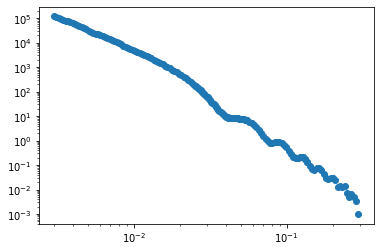

In [37]:
from matplotlib import pyplot as plt
plt.xscale('log')
plt.yscale('log')
plt.scatter(indf.loc[:,'q'], train_curves[0])


In [38]:
for i in range(ecurves.shape[0]):
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(indf.loc[:,'q'], ecurves[i,:])
    plt.title("%s %s"%(files[i].replace(".csv",""), rpreds[i]))
    plt.xlabel(r'Q, ($\AA^{-1}$')
    plt.ylabel(r'I(Q) (cm$^{-1}$)')
    plt.savefig("resplots/%s"%(files[i].replace(".csv", ".png")))
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [39]:
def find_bounds(params, labels, target):
    target_ranges = {}
    valid = np.where(labels==target)[0]
    for (key, values) in params.items():
        vals = values[valid]
        if key in numeric_params and all(np.isfinite(vals)):
          #  try:
               vmin = np.min(vals)
               vmax = np.max(vals)
               if np.isfinite(vmin) and np.isfinite(vmax):
                   target_ranges[key] = {"min": vmin, "max": vmax}
         #   except:
         #      print('excepting %s %s'%(target, key))
        else:
            if vals[0] is not None:
                vmin = vals[0]
                vmax = vals[0]
                if vmin is not np.nan:
                     target_ranges[key] = {"min": vmin, "max": vmax}
    return(target_ranges)

In [40]:
ranges = {target:find_bounds(train_params, train_labels, target) for target in np.unique(train_labels)}
for t in np.unique(train_labels):
    print(t)
    outfile = open('%s_range.csv'%(t), 'w')
    for (key,vals) in ranges[t].items():
        outfile.write("%s,%s,%s\n"%(key, str(vals['min']), str(vals['max'])))
    outfile.close()

core_shell_sphere
disk
flexible_cylinder_elliptical
multilayer_vesicle


In [41]:
print(ranges['flexible_cylinder_elliptical'])

{'radius': {'min': np.float64(20.01800565797654), 'max': np.float64(39.9995991266732)}, 'length': {'min': np.float64(3500.0), 'max': np.float64(3500.0)}, 'kuhn_length': {'min': np.float64(200.12721155050698), 'max': np.float64(499.47991792133377)}, 'radius_pd': {'min': np.float64(0.3), 'max': np.float64(0.3)}, 'radius_pd_type': {'min': 'schulz', 'max': 'schulz'}, 'scale': {'min': np.float64(0.0014123064787844458), 'max': np.float64(0.1498785372118768)}, 'sld': {'min': np.float64(0.9), 'max': np.float64(0.9)}, 'radius_pd_n': {'min': np.float64(8.0), 'max': np.float64(8.0)}, 'radius_pd_nsigma': {'min': np.int64(30), 'max': np.int64(30)}, 'axis_ratio': {'min': np.float64(8.92281080423833), 'max': np.float64(8.92281080423833)}, 'background': {'min': np.float64(0.003), 'max': np.float64(0.003)}, 'sld_solvent': {'min': np.float64(6.4), 'max': np.float64(6.4)}, 'thickness': {'min': np.float64(nan), 'max': np.float64(nan)}, 'sld_shell': {'min': np.float64(nan), 'max': np.float64(nan)}, 'sld_co

In [42]:
np.unique(targets)

array([{'flexible_cylinder_elliptical': <function random_wormlike_micelle at 0x78962a2be3b0>, 'core_shell_sphere': <function random_cs_sphere at 0x78962a2bdd80>, 'multilayer_vesicle': <function random_MLS at 0x78962a2bcb80>, 'disk': <function random_disk at 0x78962a2bd000>}],
      dtype=object)

In [43]:
print(len(np.unique(train_params['radius'])))

4000


In [44]:
for t in np.unique(train_labels):
    valid = np.where(train_labels == t)[0]
    print("%s %f"%(t, np.mean(log_train[valid,0])))

core_shell_sphere 2.614293
disk 3.130667
flexible_cylinder_elliptical 5.263826
multilayer_vesicle 2.037963


In [45]:
print(len(np.unique(train_params['scale'])))

4000


In [46]:
print(train_params.keys())

dict_keys(['radius', 'length', 'kuhn_length', 'radius_pd', 'radius_pd_type', 'scale', 'sld', 'radius_pd_n', 'radius_pd_nsigma', 'axis_ratio', 'background', 'sld_solvent', 'thickness', 'sld_shell', 'sld_core', 'n_shells', 'thick_shell', 'thick_solvent', 'length_pd', 'length_pd_n', 'length_pd_type'])


In [47]:
for (i, curve) in enumerate(log_exp):
    print("%d %s %f %s"%(i, files[i], curve[0], rpreds[i]))

0 S_r30369_10pBicelle_0mM_NaCl.csv 1.524022 core_shell_sphere
1 S_r30389_1p0_Bicelles_0mM_NaCl.csv 2.345782 disk
2 S_r30371_10pBicelles_1mM_NaCl.csv 1.663067 core_shell_sphere
3 S_r30387_5p0_Bicelles_500mM_NaCl.csv 1.646280 core_shell_sphere
4 S_r30403_0p1_Bicelles_10mM_NaCl.csv 1.206648 core_shell_sphere
5 S_r30375_10pBicelle_100mM_NaCl.csv 1.695179 core_shell_sphere
6 S_r30385_5p0_Bicelles_100mM_NaCl.csv 1.741472 disk
7 S_r30381_5p0_Bicelles_1mM_NaCl.csv 1.894408 disk
8 S_r30401_0p1_Bicelles_1mM_NaCl.csv 1.015591 core_shell_sphere
9 S_r30397_1p0_Bicelles_500mM_NaCl.csv 2.811334 core_shell_sphere
10 S_r30395_1p0_Bicelles_100mM_NaCl.csv 2.920660 core_shell_sphere
11 S_r30373_10pBicelle_10mM_NaCl.csv 1.729722 core_shell_sphere
12 S_r30393_1p0_Bicelles_10mM_NaCl.csv 2.436302 disk
13 S_r30399_0p1_Bicelles_0mM_NaCl.csv 1.068016 core_shell_sphere
14 S_r30377_10pBicelle_500mM_NaCl.csv 1.609061 core_shell_sphere
15 S_r30379_5p0_Bicelles_0mM_NaCl.csv 1.711434 disk
16 S_r30383_5p0_Bicelles_10mM

In [48]:
def compare_scale(index, title = None):
    scales_to_test = np.linspace(0.005, 0.2, 100)
    mn = train_labels[index]
    if mn in model_names.keys():
        model_name = model_names[mn]
    else:
        model_name = mn
    tcurves = []
    tdict = {p:i[index] for (p,i) in train_params.items() if should_include_param(i[index])}
    print(tdict)
    calcs, sds = vi.construct_calculators(model_name)
    for s in scales_to_test:
        tdict['scale'] = s
        tcurves += [np.array(vi.generate(model_name, tdict, calcs, sds)[0])]
    intensities = [np.log10(c)[0] for c in tcurves]
    plt.scatter(scales_to_test, intensities)
    if title is not None:
        plt.title(title)
    plt.show()

In [49]:
def should_include_param(val):
    return_value = True
    if val is None:
        return_value = False
    elif type(val) == np.float64:
        if not np.isfinite(val):
            return_value = False
    elif type(val) == np.int64:
        if not np.isfinite(val) or val < 0:
            return_value = False
    return(return_value)

{'radius': np.float64(236.71483405489144), 'radius_pd': np.float64(0.3801300705155929), 'radius_pd_type': 'schulz', 'scale': np.float64(0.0717633263035652), 'radius_pd_n': np.float64(8.0), 'radius_pd_nsigma': np.int64(30), 'background': np.float64(0.003), 'sld_solvent': np.float64(6.4), 'thickness': np.float64(31.788414078959594), 'sld_shell': np.float64(1.0), 'sld_core': np.float64(6.9955541338174)}


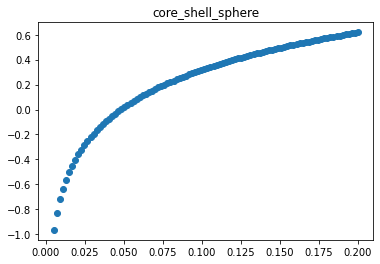

{'radius': np.float64(135.5960515857782), 'length': np.float64(59.70411178377901), 'radius_pd': np.float64(0.2779554838212517), 'radius_pd_type': 'schulz', 'scale': np.float64(0.03505851886416893), 'sld': np.float64(0.47874713422547166), 'radius_pd_n': np.float64(8.0), 'radius_pd_nsigma': np.int64(30), 'background': np.float64(0.003), 'sld_solvent': np.float64(6.4), 'length_pd': np.float64(0.3), 'length_pd_n': np.int64(40), 'length_pd_type': 'schulz'}


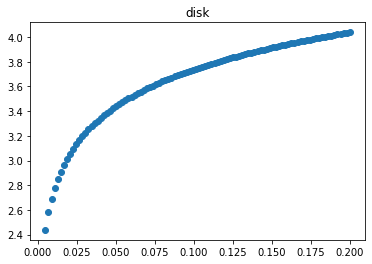

{'radius': np.float64(20.188036371334917), 'length': np.float64(3500.0), 'kuhn_length': np.float64(212.21521143540934), 'radius_pd': np.float64(0.3), 'radius_pd_type': 'schulz', 'scale': np.float64(0.04188122962843296), 'sld': np.float64(0.9), 'radius_pd_n': np.float64(8.0), 'radius_pd_nsigma': np.int64(30), 'axis_ratio': np.float64(4.378171500724377), 'background': np.float64(0.003), 'sld_solvent': np.float64(6.4)}


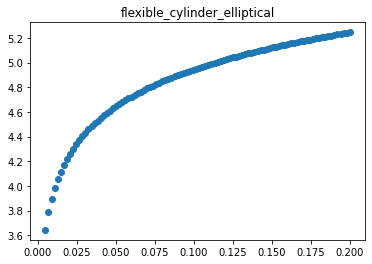

{'radius': np.float64(167.21536265880707), 'radius_pd': np.float64(0.24578472028102602), 'radius_pd_type': 'schulz', 'scale': np.float64(0.06402450378741434), 'sld': np.float64(1.0), 'radius_pd_n': np.float64(8.0), 'radius_pd_nsigma': np.int64(30), 'background': np.float64(0.003), 'sld_solvent': np.float64(6.4), 'n_shells': np.int64(15), 'thick_shell': np.float64(35.57736095232767), 'thick_solvent': np.float64(91.72854330536785)}


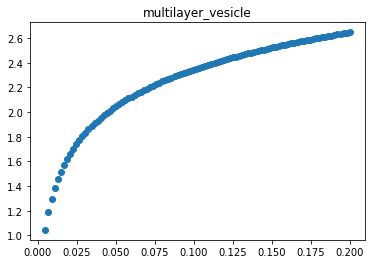

In [50]:
target = 'flexible_cylinder_elliptical'
for target in np.unique(train_labels):
    compare_scale(np.random.choice(np.where(train_labels == target)[0]), title = target)

Index(['q', 'I', 'dI', 'dq'], dtype='object')
0      0.003000
1      0.003107
2      0.003217
3      0.003331
4      0.003449
         ...   
157    0.256502
158    0.265609
159    0.275039
160    0.284804
161    0.294915
Name: q, Length: 162, dtype: float64


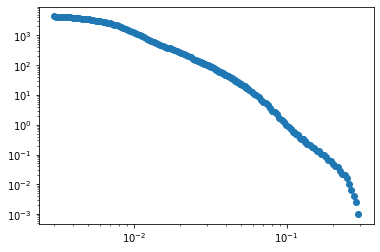

In [51]:
rind = np.random.choice(np.arange(train_labels.shape[0]))
indf = pd.DataFrame(pd.read_csv(reference_files[0], sep = '\s+'))
print(indf.columns)
q = indf.loc[:,'q']
print(q)
plt.xscale('log')
plt.yscale('log')
plt.scatter(q, train_curves[rind, :])
plt.show()

In [52]:
for (i,le) in enumerate(log_exp):
    print("%f %s"%(le[0], rpreds[i]))

1.524022 core_shell_sphere
2.345782 disk
1.663067 core_shell_sphere
1.646280 core_shell_sphere
1.206648 core_shell_sphere
1.695179 core_shell_sphere
1.741472 disk
1.894408 disk
1.015591 core_shell_sphere
2.811334 core_shell_sphere
2.920660 core_shell_sphere
1.729722 core_shell_sphere
2.436302 disk
1.068016 core_shell_sphere
1.609061 core_shell_sphere
1.711434 disk
1.905902 disk
2.408106 disk
1.692484 core_shell_sphere
1.695699 core_shell_sphere


In [53]:
def plot_sample(train_curves, train_labels, target):
    valid = np.where(train_labels==target)[0]
    np.random.shuffle(valid)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(target)
    for i in valid[:5]:
       plt.scatter(q, train_curves[i])
    plt.show()

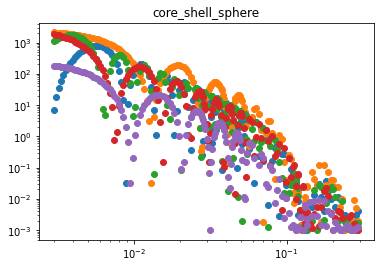

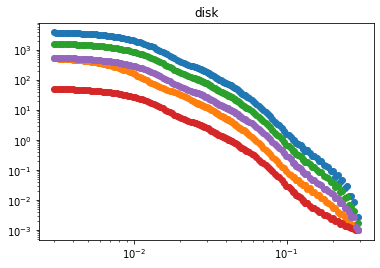

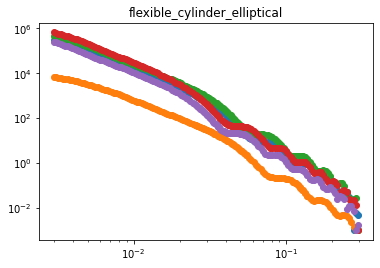

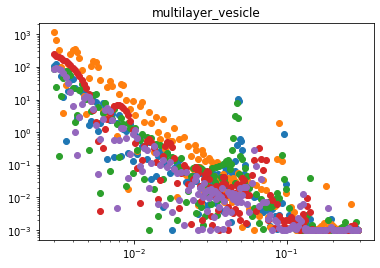

In [54]:
for t in np.unique(train_labels):
    plot_sample(train_curves, train_labels, t)

In [55]:
import TreeEncoder
encodefile = open("trained_tree_temp.json", 'w')
encodefile.write(json.dumps(tree, cls=TreeEncoder.TreeEncoder, indent=3))

470335

In [56]:
print((2 * np.pi)/0.3)
print((2*np.pi)/np.min(q))

20.943951023931955
2094.3951023931954


In [57]:
0.002*np.ones(train_curves.shape)+(np.random.normal(size = train_curves.shape)*0.001)

array([[ 2.11353366e-03,  1.36735559e-03,  4.08855599e-03, ...,
         3.07264746e-03,  3.53340761e-03,  1.75820505e-03],
       [ 1.48458904e-03, -6.97406775e-04,  2.92994077e-03, ...,
         2.61792879e-03,  1.98975347e-03,  1.87214548e-03],
       [ 2.02846039e-03,  2.08994948e-03,  3.53303419e-03, ...,
         2.57528407e-03,  1.49019794e-03,  2.94668766e-03],
       ...,
       [ 2.82891242e-03,  1.02170318e-03,  3.26715544e-03, ...,
         7.46775172e-04,  2.80278172e-03,  2.83939240e-03],
       [ 3.03122545e-03, -3.94909100e-04,  2.77471811e-05, ...,
         1.37207410e-03,  2.02972101e-03,  1.41761631e-03],
       [ 8.93993048e-04,  1.31257038e-03,  2.09883422e-03, ...,
         8.41032289e-04,  1.31168329e-03,  2.36114659e-03]],
      shape=(4000, 162))

In [58]:
indf.loc[140:dI"]

SyntaxError: unterminated string literal (detected at line 1) (2027223114.py, line 1)

In [59]:
import re
def order_experimental(predictions, filenames):
    mask = re.compile(r'S_r([0-9]+).*')
    keys = np.zeros(len(filenames), dtype=int)
    for i,fn in enumerate(filenames):
        keys[i] = mask.match(fn).groups()[0]
    order = np.argsort(keys)
    print(predictions)
    for o in order:
        print("%d %s"%(keys[o], predictions[o]))

In [60]:
order_experimental(rpreds, files)

[np.str_('core_shell_sphere') np.str_('disk') np.str_('core_shell_sphere')
 np.str_('core_shell_sphere') np.str_('core_shell_sphere')
 np.str_('core_shell_sphere') np.str_('disk') np.str_('disk')
 np.str_('core_shell_sphere') np.str_('core_shell_sphere')
 np.str_('core_shell_sphere') np.str_('core_shell_sphere') np.str_('disk')
 np.str_('core_shell_sphere') np.str_('core_shell_sphere') np.str_('disk')
 np.str_('disk') np.str_('disk') np.str_('core_shell_sphere')
 np.str_('core_shell_sphere')]
30369 core_shell_sphere
30371 core_shell_sphere
30373 core_shell_sphere
30375 core_shell_sphere
30377 core_shell_sphere
30379 disk
30381 disk
30383 disk
30385 disk
30387 core_shell_sphere
30389 disk
30391 disk
30393 disk
30395 core_shell_sphere
30397 core_shell_sphere
30399 core_shell_sphere
30401 core_shell_sphere
30403 core_shell_sphere
30405 core_shell_sphere
30407 core_shell_sphere


In [ ]:
indf = pd.DataFrame(pd.read_csv(files[0]))
uncertainties = np.zeros((len(files), indf.loc[:,'dI'].shape[0]))
for i,fn in enumerate(files):
    indf = pd.Dataframe(pd.read_csv(files[i], sep='\s+'))
    uncertainties[i] = indf.loc[:,'dI']
mean_uncertainties = 

In [ ]:
morphdict = {30369:, ["disk"],
            30371: ["disk"], 
            30373: ["disk"],
            30375:["disk", "core_shell_sphere"],
            30377: ["disk"],
            30379: ["disk", "flexible_cylinder_elliptical"],
            30381: ["disk", "flexible_cylinder_elliptical"],
            30383: ["flexible_cylinder_elliptical"],
            30385: ["flexible_cylinder_elliptical", "disk"],
            30387: ["flexible_cylinder_Elliptical", "disk"],
            30389: ["core_shell_sphere", "flexible_cylinder_elliptical"],
            30391: ["flexible_cylinder_elliptical", "core_shell_sphere"],
            30393: ["flexible_cylinder_Elliptical", "core_shell_sphere"],
            30395: ["core_shell_sphere", "multilayer_vesivle"],
            30397: ["multilayer_vesicle", "core_Shell_sphere"],
            30399: ["core_shell_sphere"],
            30401: ["core_shell_sphere"],
            30403: ["core_shell_sphere"],
            30405: ["core_shell_sphere","multilayer_sphere"],
            30407: ["multilayer_vesicle", "core_shell_sphere"]}